In [1]:
import os
import sys
import socket
import pickle
import importlib
import itertools
import functools
import collections
import logging
logging.basicConfig(level=logging.INFO)

import tqdm

import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import xgboost as xgb

from statsmodels.stats.multitest import multipletests

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV

# Figure out local paths
SRC_DIR = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'rnagps')
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import data_loader
import model_utils
import plotting_utils
import utils
import seq

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots")
assert os.path.isdir(PLOT_DIR)

np.random.seed(27492)
SEED = 27492

print('The scikit-learn version is {}.'.format(sklearn.__version__))

INFO:root:CPU


The scikit-learn version is 0.21.3.


In [69]:
K_FOLD = 5

orig_test_dataset = data_loader.LocalizationClassificationKmers("test", k_fold=K_FOLD)
orig_test_data = data_loader.load_data_as_np(orig_test_dataset)

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 120/366 = 0.32786885245901637 positive
INFO:root:Lma - 71/366 = 0.19398907103825136 positive
INFO:root:Mito - 32/366 = 0.08743169398907104 positive
INFO:root:Nes - 26/366 = 0.07103825136612021 positive
INFO:root:Nik - 143/366 = 0.3907103825136612 positive
INFO:root:Nls - 80/366 = 0.2185792349726776 positive
INFO:root:NucPore - 17/366 = 0.04644808743169399 positive
INFO:root:Omm - 80/366 = 0.2185792349726776 positive
INFO:root:324	0.8852459016393442	protein_coding
INFO:root:14	0.03825136612021858	lincRNA
INFO:root:9	0.02459016393442623	antisense_RNA
INFO:root:7	0.01912568306010929	processed_pseudogene
INFO:root:5	0.01366120218579235	transcribed_unprocessed_pseudogene
INFO:root:2	0.00546448087431694	transcribed_processed_pseudogene
INFO:root:1	0.

In [72]:
orig_test_transcripts = [orig_test_dataset.get_representative_trans(orig_test_dataset.full_deseq_table.index[i]) for i in range(len(orig_test_dataset))]
orig_test_transcripts[:5]

['ENST00000263346.12',
 'ENST00000310421.4',
 'ENST00000611696.3',
 'ENST00000503882.1',
 'ENST00000519694.1']

In [2]:
importlib.reload(data_loader)

train_dataset = data_loader.LocalizationTranscriptClassiifcationKmers("train", k_fold=K_FOLD, dup_only=False)
valid_dataset = data_loader.LocalizationTranscriptClassiifcationKmers("valid", k_fold=K_FOLD, dup_only=False)
test_dataset = data_loader.LocalizationTranscriptClassiifcationKmers("test", k_fold=K_FOLD, dup_only=False)
full_dataset = data_loader.LocalizationTranscriptClassiifcationKmers("all", k_fold=K_FOLD, dup_only=False)
train_data = data_loader.load_data_as_np(train_dataset)
valid_data = data_loader.load_data_as_np(valid_dataset)
test_data = data_loader.load_data_as_np(test_dataset)
full_data = data_loader.load_data_as_np(full_dataset)

INFO:root:Dropping 217186/218166 rows for having no localizations that pass significance
INFO:root:Dropping 217186/218166 rows for having no localizations that pass significance
INFO:root:Dropping 217186/218166 rows for having no localizations that pass significance
INFO:root:Dropping 217186/218166 rows for having no localizations that pass significance
100%|██████████| 980/980 [00:07<00:00, 132.46it/s]


In [80]:
full_dataset_no_overlap = [tname not in set(orig_test_transcripts) for tname in full_dataset.full_deseq_table.index]
full_data = (
    full_data[0][full_dataset_no_overlap],
    full_data[1][full_dataset_no_overlap],
)

In [81]:
full_data[1].shape

(935, 8)

In [82]:
full_dataset.full_deseq_table.head()

,target_id.1,ensembl_gene,gene_name,gene_type,ctrl_tpm,Erm_tpm,Erm_b,Erm_qval,Kdel_tpm,Kdel_b,...,Nik_qval,Nls_tpm,Nls_b,Nls_qval,NucPore_tpm,NucPore_b,NucPore_qval,Omm_tpm,Omm_b,Omm_qval
target_id,,,,,,,,,,,,,,,,,,,,,
ENST00000297185.7,ENST00000297185.7,ENSG00000113013.12,HSPA9,protein_coding,199.036571,124.298586,-0.500664,7.300728e-04,167.456558,-0.206815,...,0.153527,191.570350,-0.060530,0.848998,148.272696,-0.314651,0.398026,183.189452,-0.106336,0.997281
ENST00000463181.5,ENST00000463181.5,ENSG00000122566.20,HNRNPA2B1,protein_coding,10.007578,7.528005,-0.123166,9.576001e-01,11.710190,0.304018,...,0.236545,84.803354,2.297576,0.000709,22.013074,0.952728,0.706161,6.447169,-0.364373,0.997281
ENST00000326587.11,ENST00000326587.11,ENSG00000179222.17,MAGED1,protein_coding,149.286797,62.000399,-0.903415,1.687734e-08,175.292211,0.135425,...,0.000075,115.955432,-0.267697,0.547485,144.228238,-0.051926,0.999715,57.671580,-1.105680,0.000003
ENST00000340913.10,ENST00000340913.10,ENSG00000135486.17,HNRNPA1,protein_coding,659.057756,321.604782,-0.781564,2.240898e-07,559.633026,-0.192480,...,0.651378,636.909331,-0.055621,0.858521,679.334133,0.017314,0.999715,506.255821,-0.291686,0.695290
ENST00000402752.5,ENST00000402752.5,ENSG00000099901.16,RANBP1,protein_coding,156.260712,46.228985,-1.243661,5.952071e-05,137.001519,-0.125373,...,0.302816,134.244244,-0.145785,0.808279,127.348174,-0.189151,0.934806,72.448811,-0.755368,0.104973


In [83]:
rf = utils.load_sklearn_model(os.path.join(
    os.path.dirname(SRC_DIR),
    "models/rf_8way_fold5.0.21.3.skmodel"
))

In [84]:
random_classifier = model_utils.RandomClassifier(8)
rand_matrix = random_classifier.predict_proba(full_data[0])

rand_class_perf = model_utils.generate_multiclass_perf(full_data[1], rand_matrix, 8)
rand_overall_perf = model_utils.generate_model_perf(full_data[1], rand_matrix, multiclass=True)
print(rand_overall_perf.auroc)
print(rand_overall_perf.auprc)

0.507901456068523
0.28909062017867826


In [85]:
rf_matrix = model_utils.list_preds_to_array_preds(rf.predict_proba(full_data[0]))
rf_class_perf = model_utils.generate_multiclass_perf(full_data[1], rf_matrix, 8)
rf_overall_perf = model_utils.generate_model_perf(full_data[1], rf_matrix, multiclass=True)
print(rf_overall_perf.auroc)
print(rf_overall_perf.auprc)

0.6369474251344931
0.46751327633840645


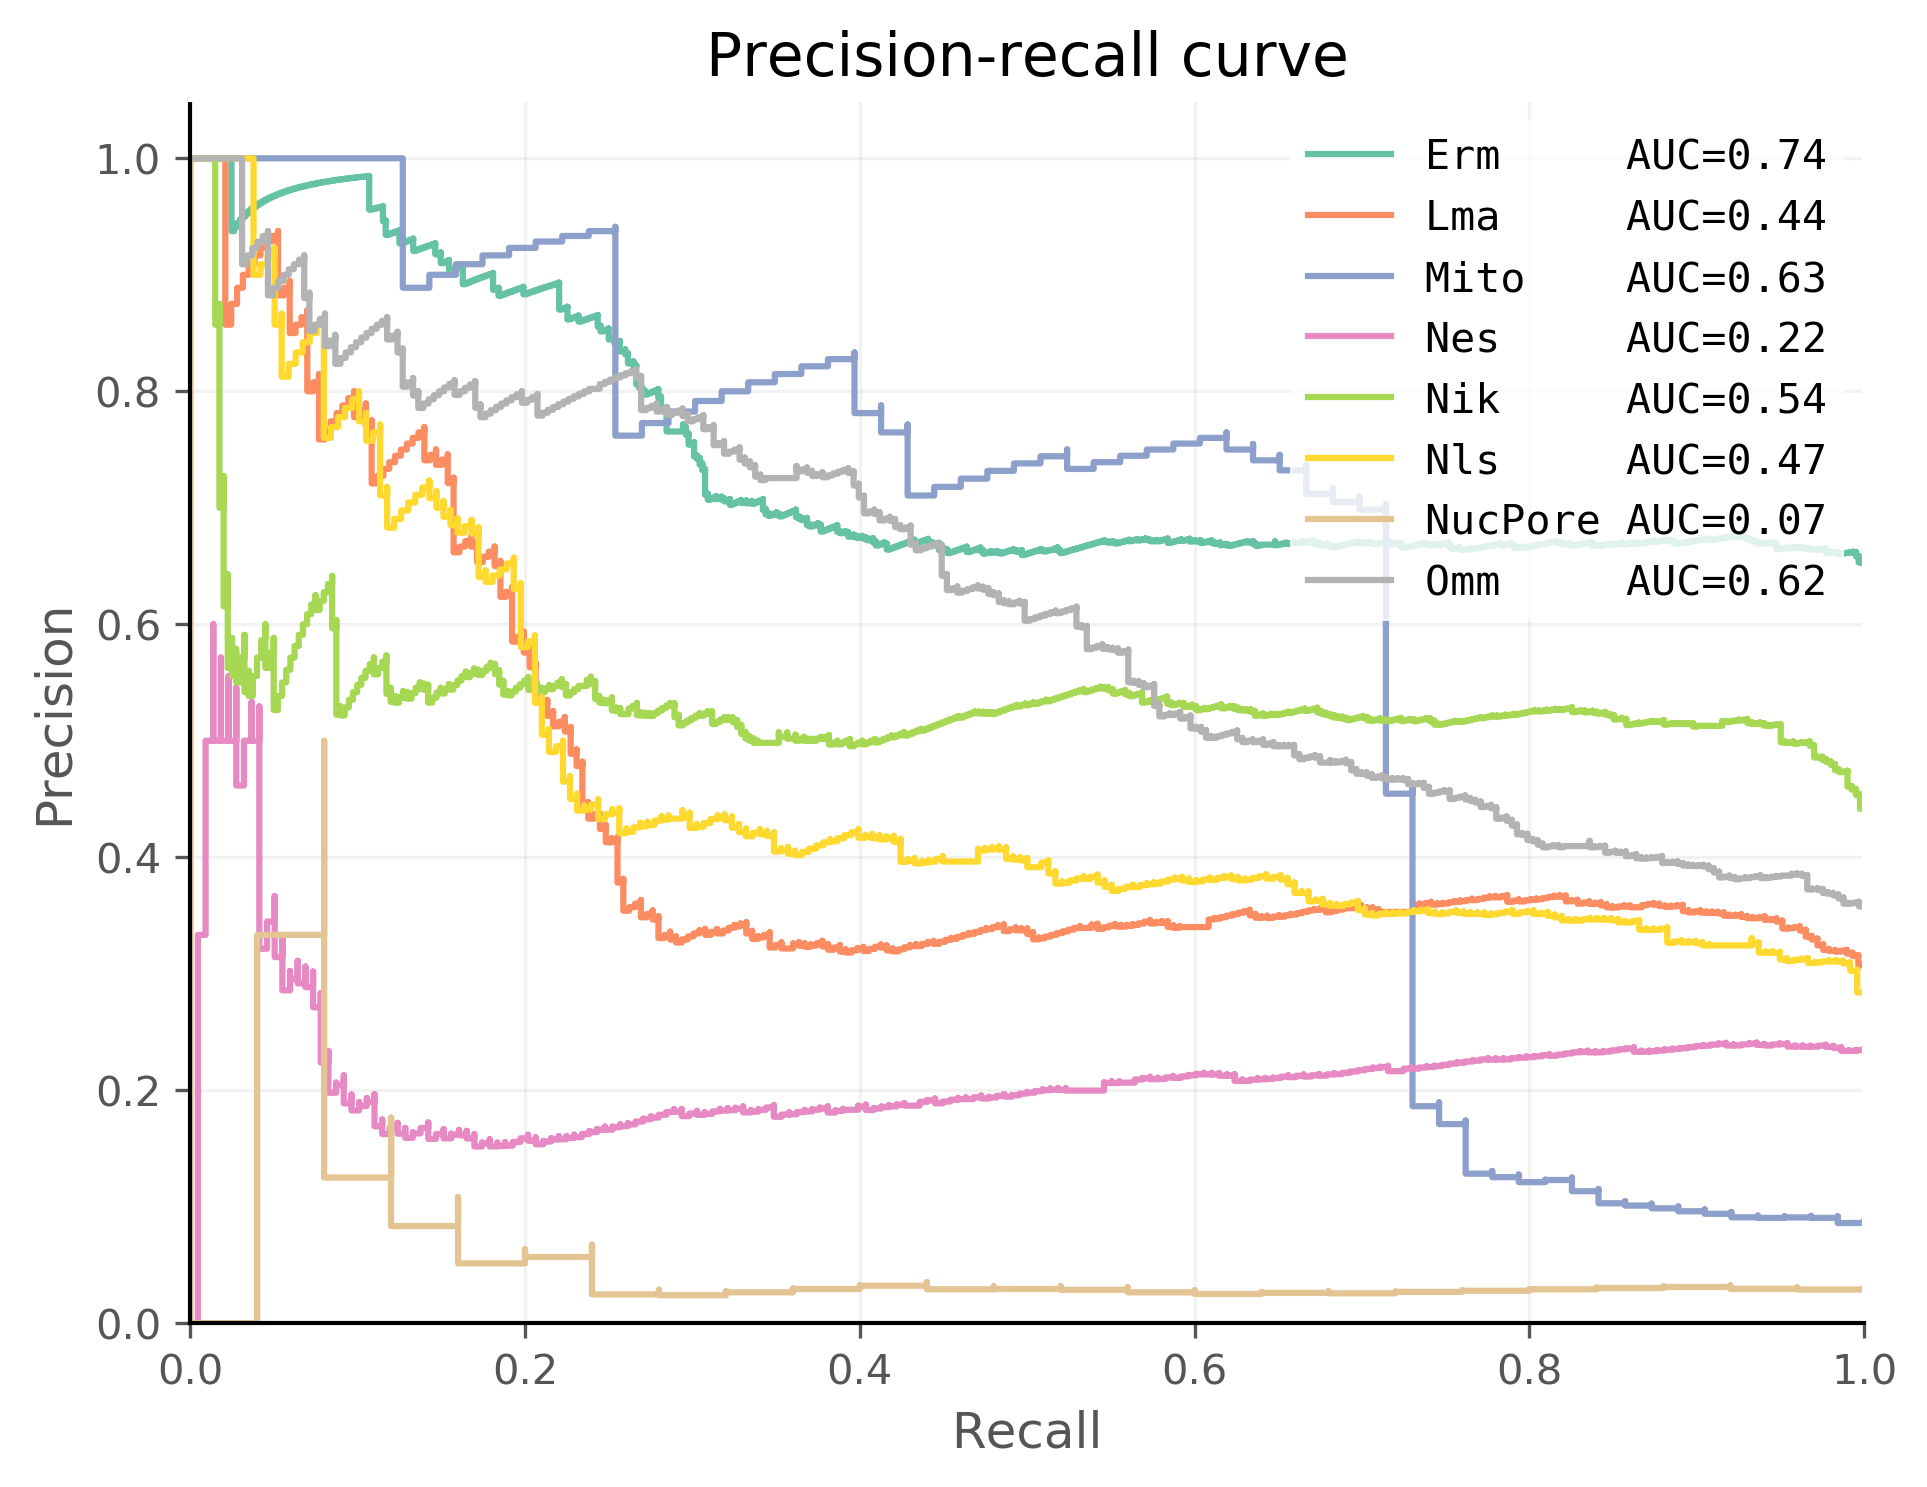

In [86]:
plotting_utils.plot_auprc(
    {localization: perf for localization, perf in zip(test_dataset.localizations, rf_class_perf)}
)

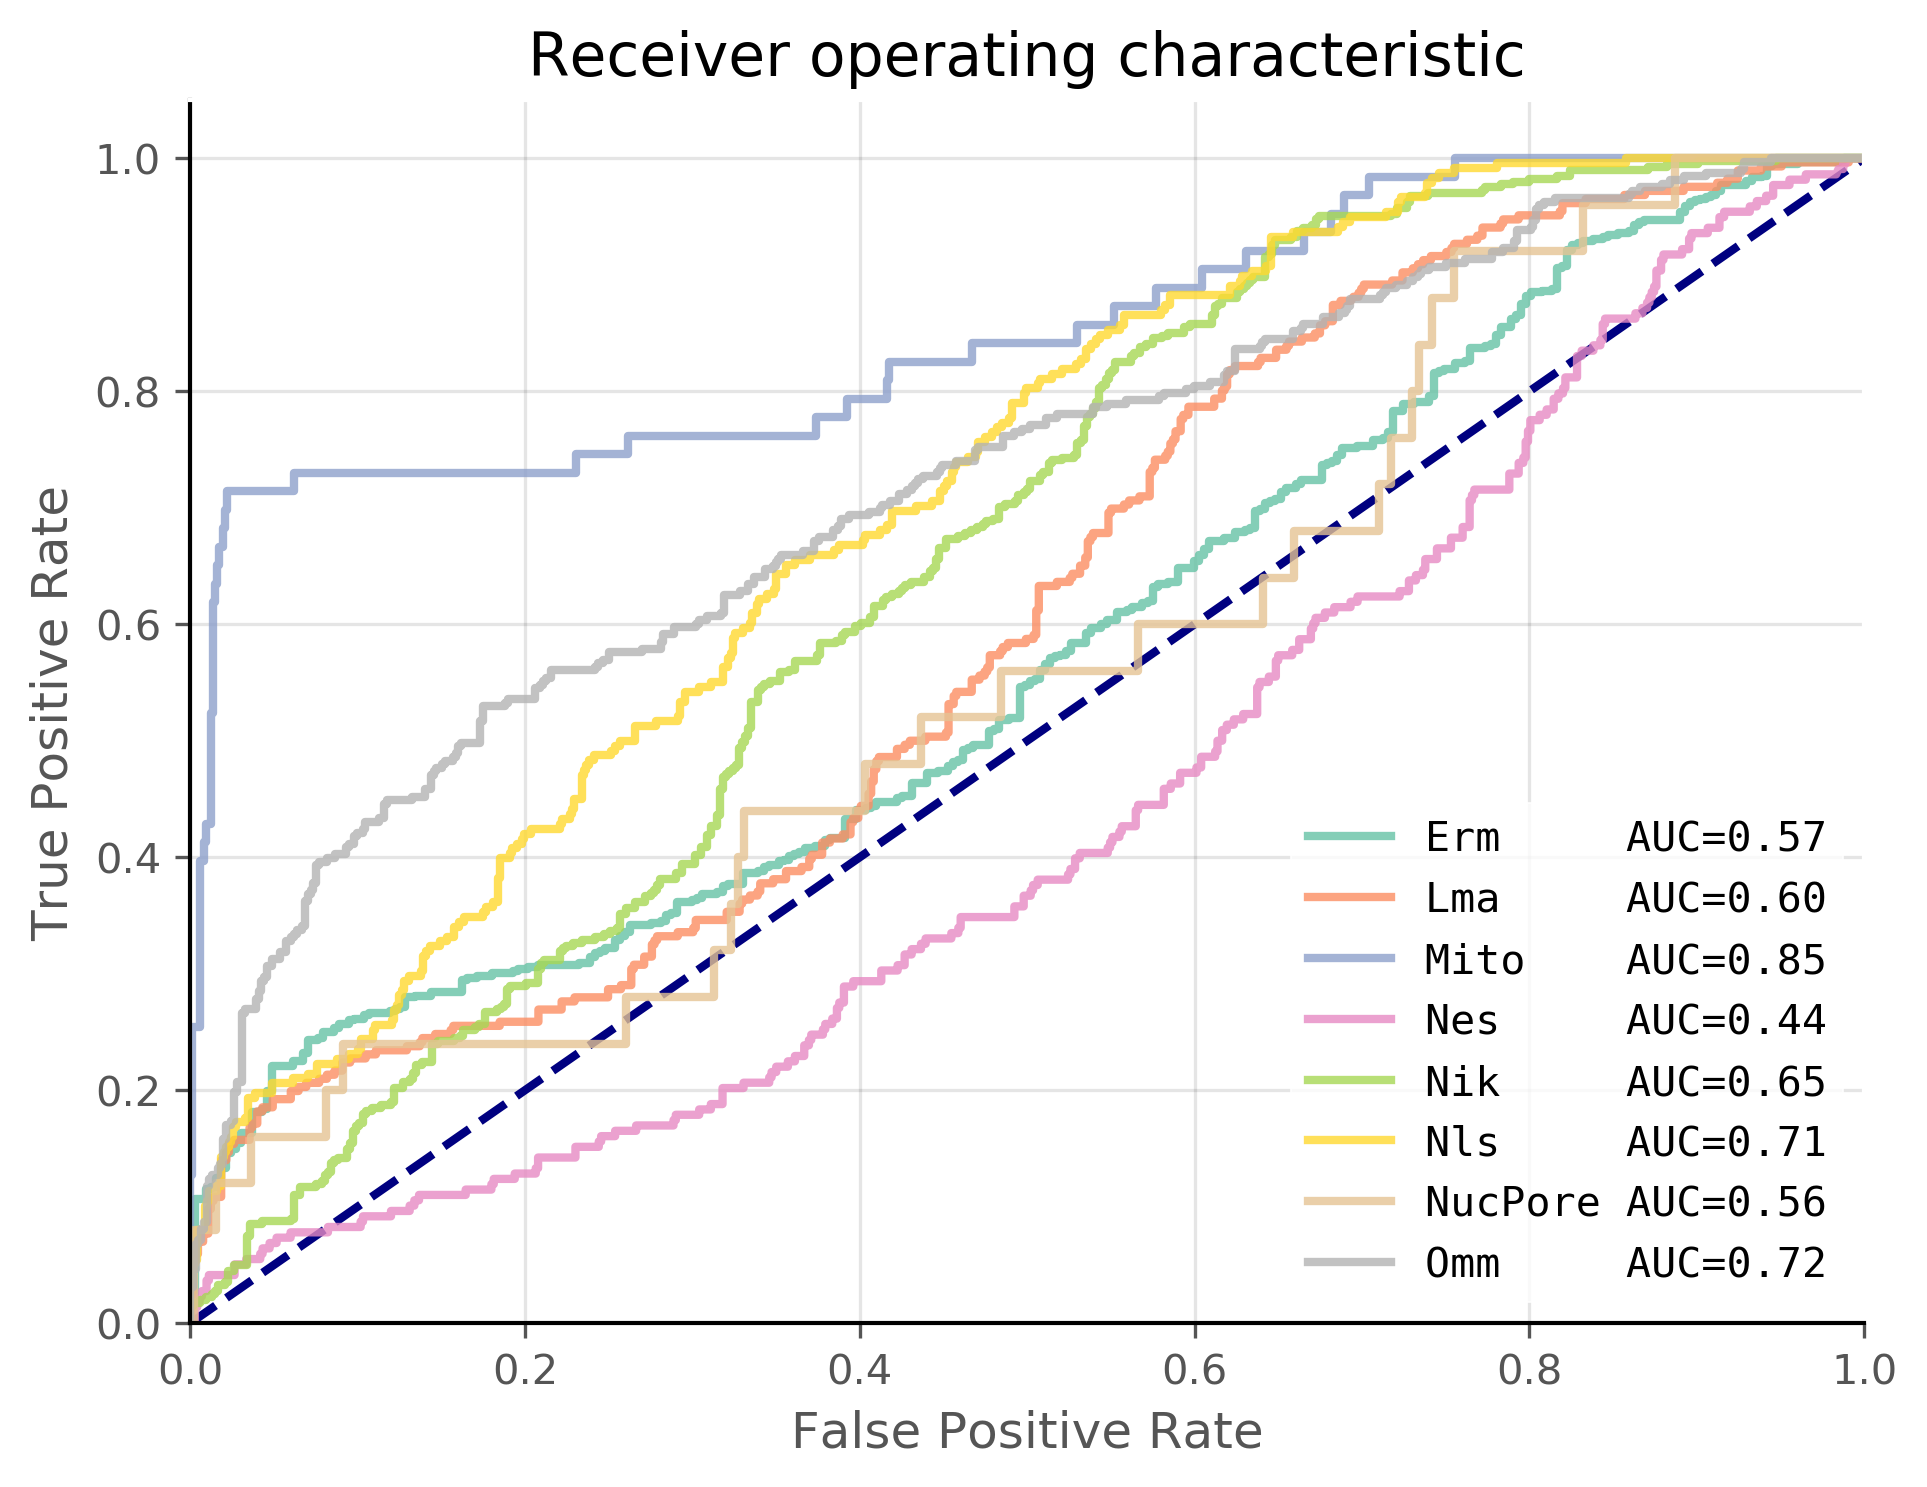

In [87]:
plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(test_dataset.localizations, rf_class_perf)}
)

In [88]:
# WE DO NOT CHECK FOR OVERLAP WITH ORIGINAL TEST SET HERE
importlib.reload(data_loader)
K_FOLD = 5
dup_only_train_dataset = data_loader.LocalizationTranscriptClassiifcationKmers("train", k_fold=K_FOLD, dup_only=True)
dup_only_valid_dataset = data_loader.LocalizationTranscriptClassiifcationKmers("valid", k_fold=K_FOLD, dup_only=True)
dup_only_test_dataset = data_loader.LocalizationTranscriptClassiifcationKmers("test", k_fold=K_FOLD, dup_only=True)
dup_only_full_dataset = data_loader.LocalizationTranscriptClassiifcationKmers("all", k_fold=K_FOLD, dup_only=True)
dup_only_train_data = data_loader.load_data_as_np(dup_only_train_dataset)
dup_only_valid_data = data_loader.load_data_as_np(dup_only_valid_dataset)
dup_only_test_data = data_loader.load_data_as_np(dup_only_test_dataset)
dup_only_full_data = data_loader.load_data_as_np(dup_only_full_dataset)

INFO:root:Dropping 217186/218166 rows for having no localizations that pass significance
INFO:root:Dropping 217186/218166 rows for having no localizations that pass significance
INFO:root:Dropping 217186/218166 rows for having no localizations that pass significance
INFO:root:Dropping 217186/218166 rows for having no localizations that pass significance
100%|██████████| 205/205 [00:02<00:00, 89.55it/s] 


In [89]:
random_dup_classifier = model_utils.RandomClassifier(8)
rand_dup_only_matrix = random_dup_classifier.predict_proba(dup_only_full_data[0])

rand_dup_only_class_perf = model_utils.generate_multiclass_perf(dup_only_full_data[1], rand_dup_only_matrix, 8)
rand_dup_only_overall_perf = model_utils.generate_model_perf(dup_only_full_data[1], rand_dup_only_matrix, multiclass=True)
print(rand_dup_only_overall_perf.auroc)
print(rand_dup_only_overall_perf.auprc)

0.48525529523010347
0.3208733751609408


In [90]:
rf_dup_only_matrix = model_utils.list_preds_to_array_preds(rf.predict_proba(dup_only_full_data[0]))
rf_dup_only_class_perf = model_utils.generate_multiclass_perf(dup_only_full_data[1], rf_dup_only_matrix, 8)
rf_dup_only_overall_perf = model_utils.generate_model_perf(dup_only_full_data[1], rf_dup_only_matrix, multiclass=True)
print(rf_dup_only_overall_perf.auroc)
print(rf_dup_only_overall_perf.auprc)

0.5426823599812339
0.4002730093627255


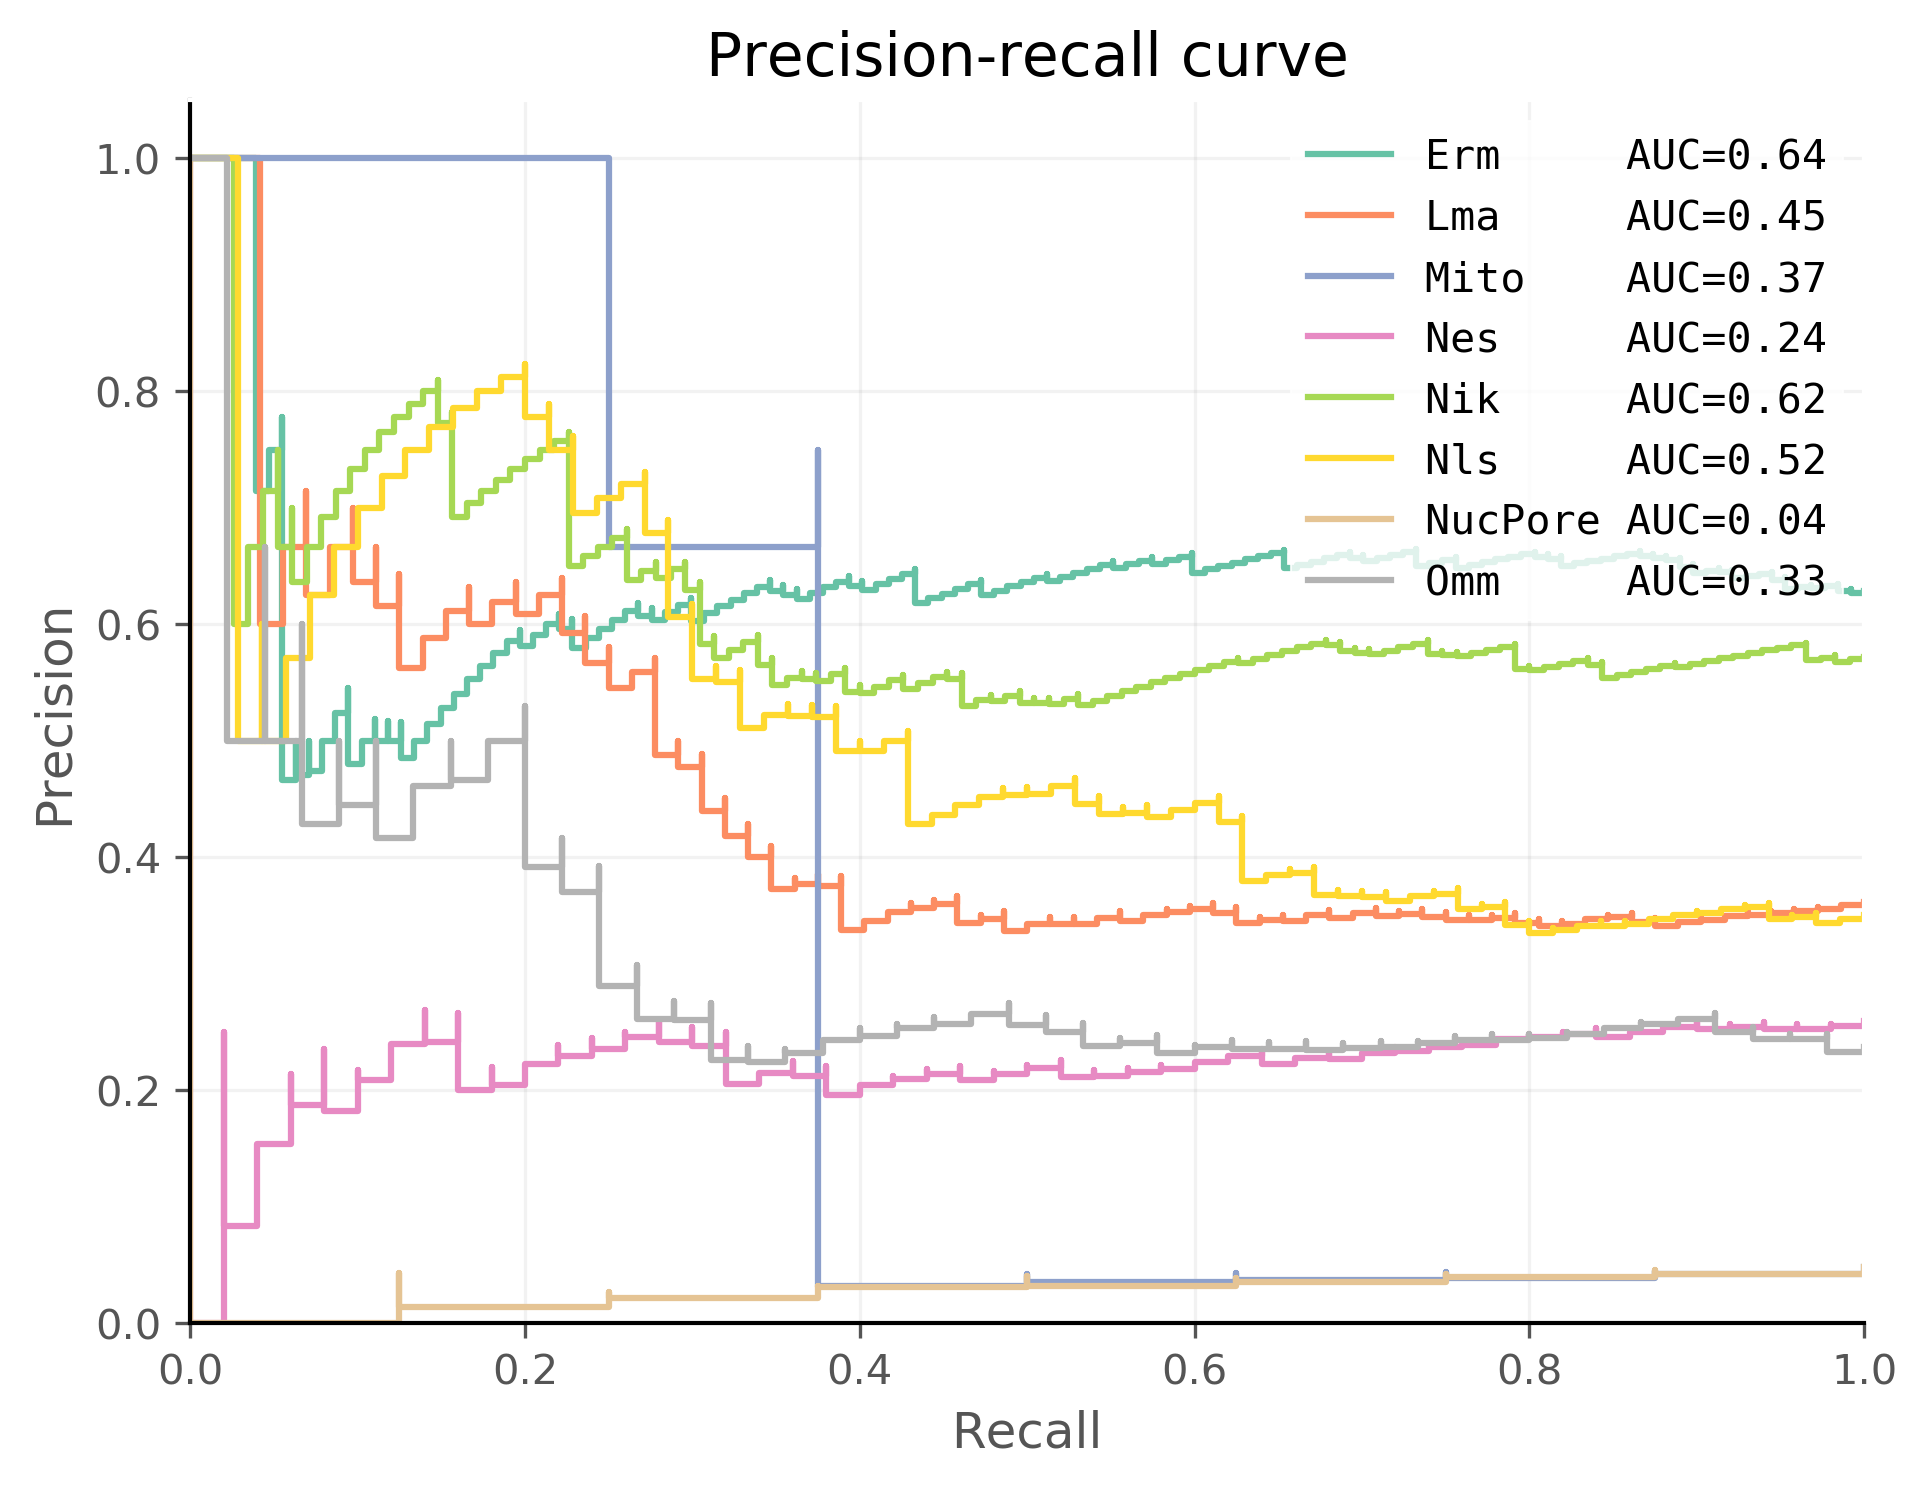

In [91]:
plotting_utils.plot_auprc(
    {localization: perf for localization, perf in zip(test_dataset.localizations, rf_dup_only_class_perf)}
)

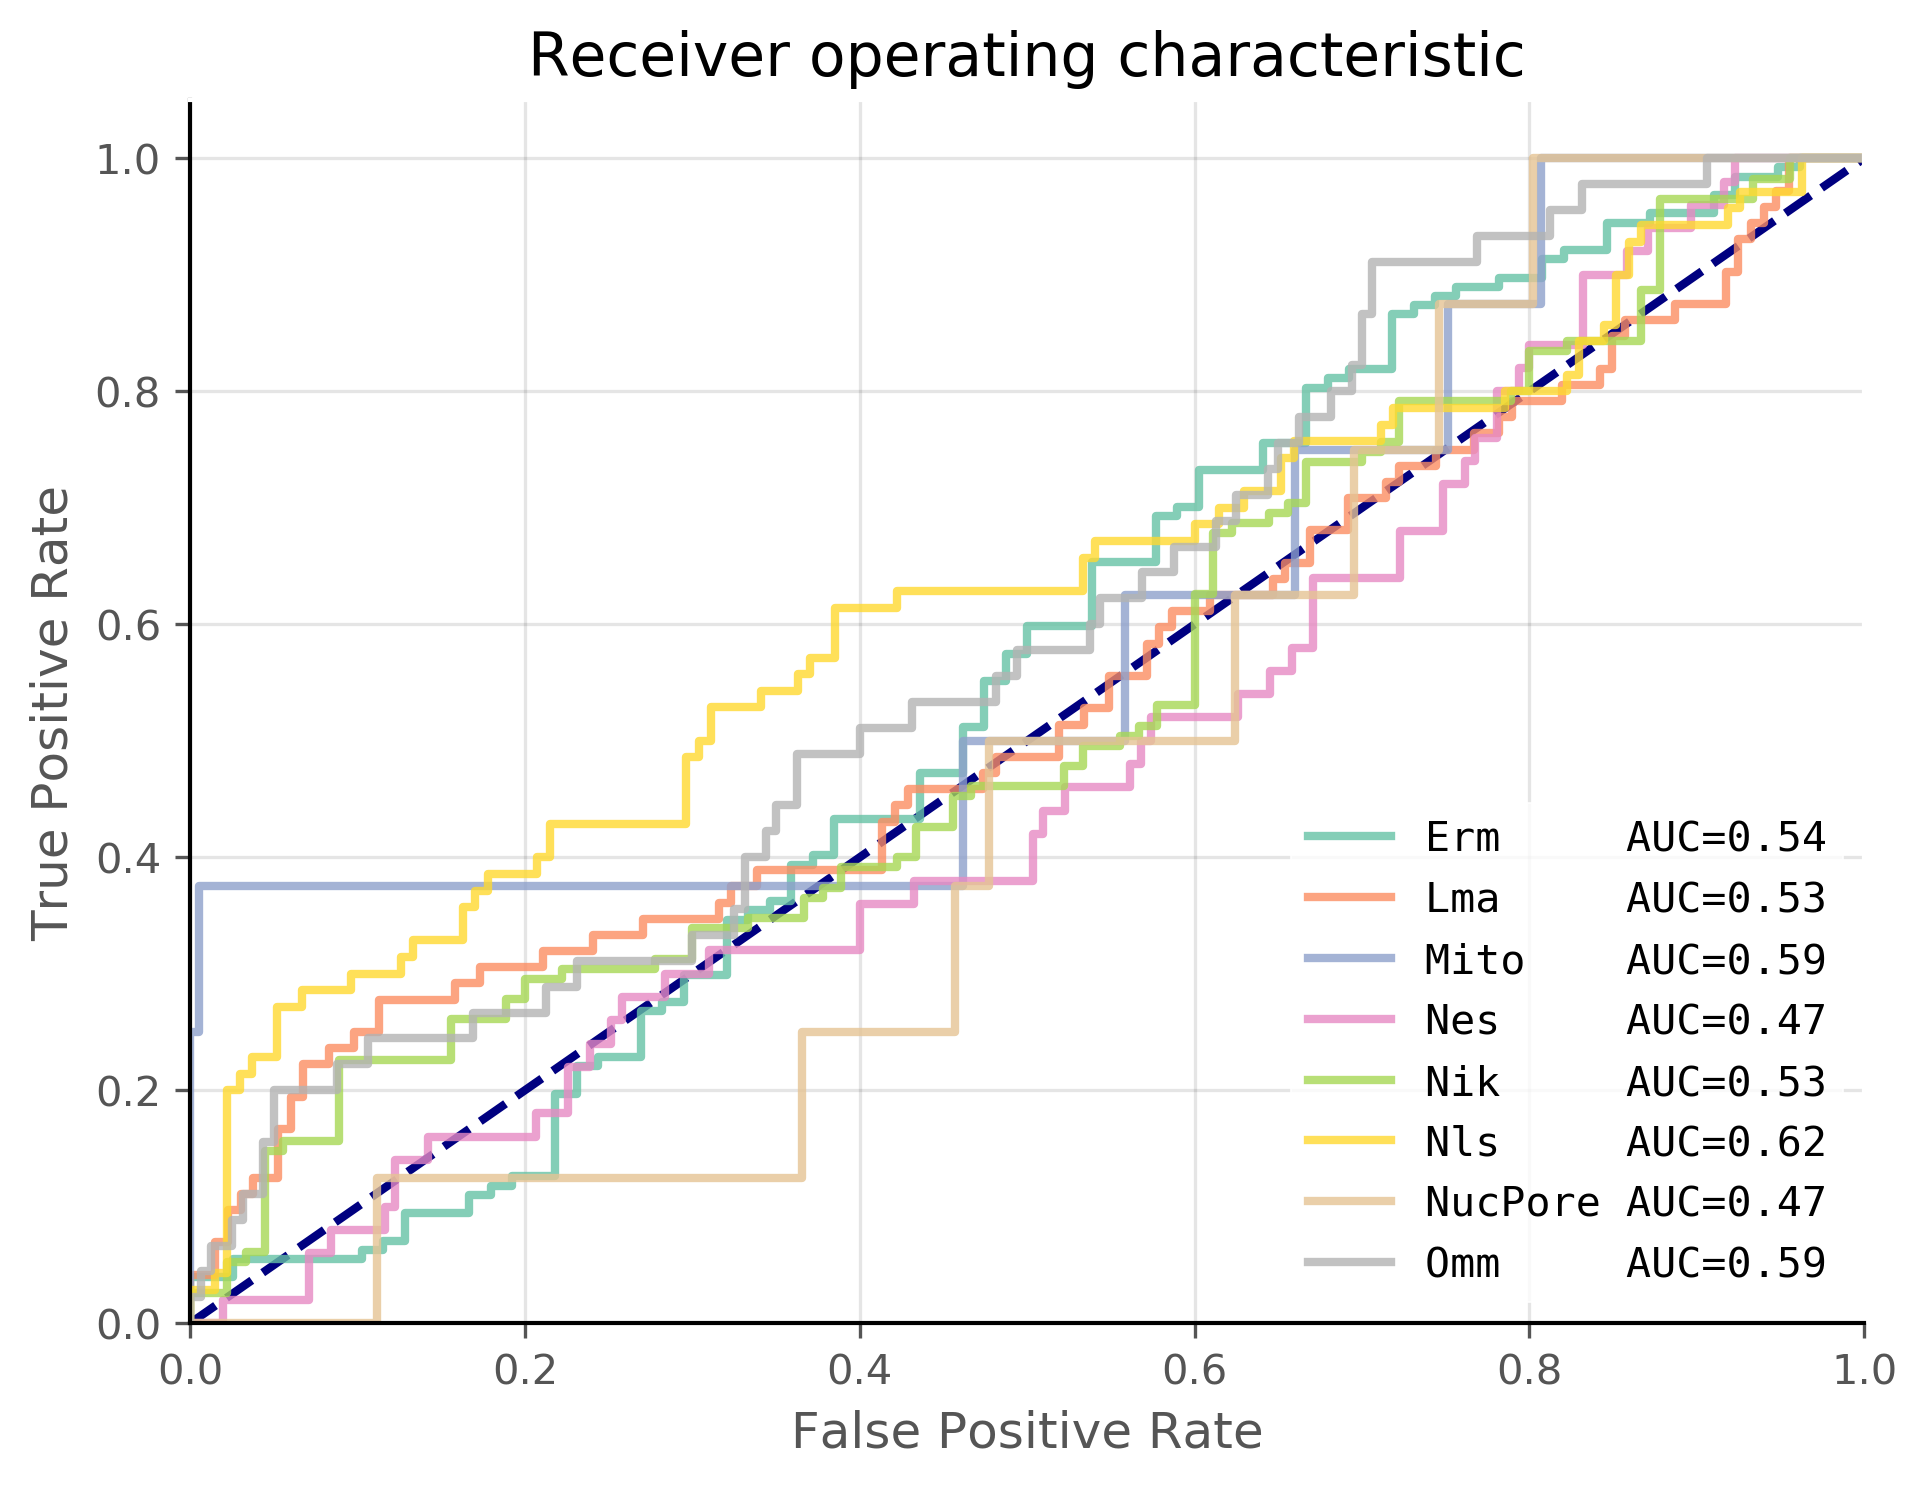

In [92]:
plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(test_dataset.localizations, rf_dup_only_class_perf)}
)

## Try to find examples
Try to find examples where we can correctly predict two different transcript isoforms of the same gene

In [93]:
unique_genes, unique_genes_idx = np.unique(dup_only_full_dataset.full_deseq_table['ensembl_gene'], return_inverse=True)

In [94]:
len(unique_genes), len(unique_genes_idx)

(88, 205)

In [95]:
# Iterate over every unique gene
unique_genes_to_pred = {}
unique_genes_to_truth = {}
for i, gene in enumerate(unique_genes):
    gene_idx = np.where(dup_only_full_dataset.full_deseq_table['ensembl_gene'] == gene)
    dup_only_full_data_sub = (
        dup_only_full_data[0][gene_idx],
        dup_only_full_data[1][gene_idx]
    )
    gene_preds = model_utils.list_preds_to_array_preds(rf.predict_proba(dup_only_full_data_sub[0]))
    assert gene not in unique_genes_to_pred
    unique_genes_to_pred[gene] = gene_preds
    unique_genes_to_truth[gene] = dup_only_full_data_sub[1]

In [96]:
unique_genes_to_pred_variation = {}
for gene, preds in unique_genes_to_pred.items():
    preds_delta = np.max(preds, axis=0) - np.min(preds, axis=0)
    preds_delta_total = np.sum(preds_delta)
    unique_genes_to_pred_variation[gene] = preds_delta_total

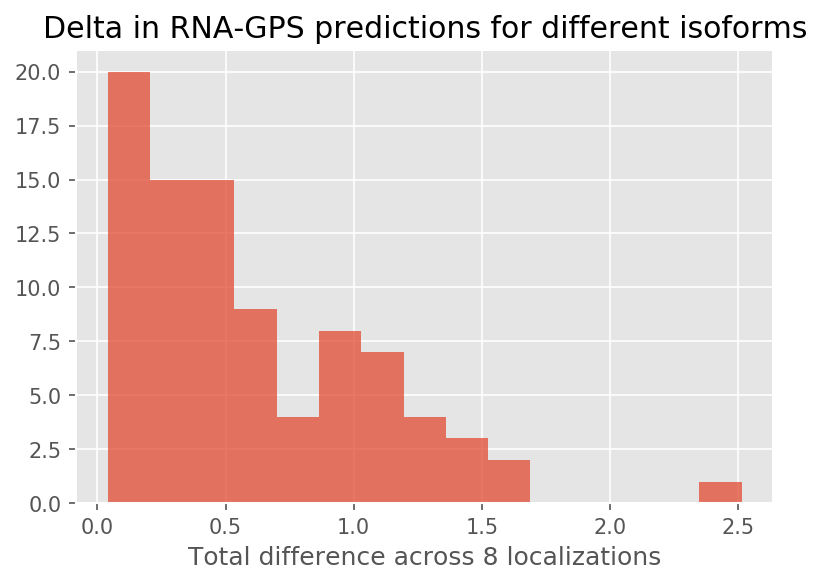

In [97]:
fig, ax = plt.subplots(dpi=150)
ax.hist(unique_genes_to_pred_variation.values(), bins=15, alpha=0.75)
ax.set(
    xlabel="Total difference across 8 localizations",
    title="Delta in RNA-GPS predictions for different isoforms"
)
fig.show()

In [98]:
print(sorted(list(unique_genes_to_pred_variation.values()), reverse=True)[:10])

[2.514087542087543, 1.5879718614718619, 1.5764821567321567, 1.5125848965848965, 1.4788879453879455, 1.394329522329522, 1.356322954822955, 1.283667628667629, 1.271459521959522, 1.2121807359307364]


In [99]:
max_variation_genes = [gene for gene, variation in unique_genes_to_pred_variation.items() if variation == 2.514087542087542]
max_variation_genes

[]

In [100]:
print(test_dataset.localizations)

('Erm', 'Lma', 'Mito', 'Nes', 'Nik', 'Nls', 'NucPore', 'Omm')


In [101]:
unique_genes_to_pred[max_variation_genes[0]]

IndexError: list index out of range

In [ ]:
unique_genes_to_truth[max_variation_genes[0]]